# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [476]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [477]:
entropy = - 2/10 * np.log(2/10) - 8/10 * np.log(8/10)
entropy.round(2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [478]:
def gini(p):
    return p*(1-p) + (1-p)*(1-(1-p))
Q = gini(0.2) - 8/10*gini(1) - 2/10*gini(0)
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [479]:
result = np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
result # Есть несколько вариантов прогноза, но самый популярный - просто взять среднее

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [480]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [807]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return Q: вектор со значениями функционала качества для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return Q_best: оптимальное значение функционала качества (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    R = len(target_vector)
    Q = []
    
    def real_class(t):
        mask = feature_vector <= t
        H = gini(np.sum(target_vector, axis = 0)/R)
        R_l = len(target_vector[mask])
        R_r = len(target_vector[~mask])
        H_l = gini(np.sum(target_vector[mask], axis = 0)/R_l)
        H_r = gini(np.sum(target_vector[~mask], axis = 0)/R_r)
        return (H - R_l*H_l/R - R_r*H_r/R) 
        
    def real_regr(t):
        mask = feature_vector <= t
        H = np.var(target_vector)
        H_l = np.var(target_vector[mask])
        H_r = np.var(target_vector[~mask])
        R_l = len(target_vector[mask])
        R_r = len(target_vector[~mask])
        return (H - R_l*H_l/R - R_r*H_r/R)
    
    def categ_class(t):
        mask = (feature_vector == t)
        H = gini(np.sum(target_vector, axis = 0)/R)
        R_l = len(target_vector[mask])
        R_r = len(target_vector[~mask])
        H_l = gini(np.sum(target_vector[mask], axis = 0)/R_l)
        H_r = gini(np.sum(target_vector[~mask], axis = 0)/R_r)
        return (H - R_l*H_l/R - R_r*H_r/R)
        
    def categ_regr(t):
        mask = (feature_vector == t)
        H = np.var(target_vector)
        H_l = np.var(target_vector[mask])
        H_r = np.var(target_vector[~mask])
        R_l = len(target_vector[mask])
        R_r = len(target_vector[~mask])
        return (H - R_l*H_l/R - R_r*H_r/R)
    
    if feature_type == "real":
        uniq_values = np.unique(feature_vector)
        if len(uniq_values) > 1:
            thresholds = (((uniq_values[::-1][:-1] - uniq_values[:-1][::-1]) / 2) + uniq_values[:-1][::-1])[::-1]
        else:
            thresholds = uniq_values 
        if task == "classification":
            real_class_vec = np.vectorize(real_class)
            Q = real_class_vec(thresholds)   
        elif task == "regression":
            real_regr_vec = np.vectorize(real_regr)
            Q = real_regr_vec(thresholds)
    elif feature_type == "categorical":
        thresholds = np.unique(feature_vector)
        if task == "classification":
            categ_class_vec = np.vectorize(categ_class)
            Q = categ_class_vec(thresholds) 
        elif task == "regression":
            categ_regr_vec = np.vectorize(categ_regr)
            Q = categ_regr_vec(thresholds)
    threshold_best = thresholds[np.argmax(Q)]
    Q_best = np.max(Q)
    return (thresholds, Q, threshold_best, Q_best)

thresholds, Q, threshold_best, Q_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

In [808]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

boston["DESCR"]
X["CRIM"].value_counts()

0.01501     2
14.33370    2
0.57834     1
0.06127     1
0.03548     1
           ..
0.25356     1
0.10469     1
0.22876     1
0.34109     1
0.26363     1
Name: CRIM, Length: 504, dtype: int64

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

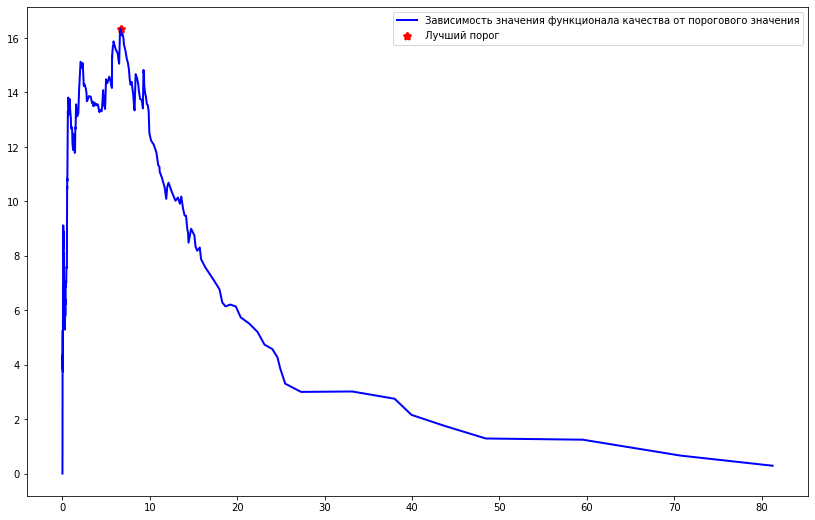

In [810]:
plt.figure(figsize=(14,9))
plt.plot(thresholds, Q, linestyle = '-', linewidth = 2, color = 'blue')
plt.scatter(threshold_best, Q_best, color='red', marker='*',linewidths=3)
plt.legend(["Зависимость значения функционала качества от порогового значения", "Лучший порог"]) 

plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [811]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова

        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        
        
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}
            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (sub_X[:, feature_best] <= threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (sub_X[:, feature_best] == threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        self.pred_class = None
        
        if node["type"] == 'nonterminal':
            feature_type = self._feature_types[node["feature_split"]]
            if feature_type == 'real':
                if x[node["feature_split"]] <= node["threshold"]:
                    self._predict_node(x, node['left_child'])
                else:
                    self._predict_node(x, node['right_child'])
            else:
                if x[node["feature_split"]] == node["category_split"]:
                    self._predict_node(x, node['left_child'])
                else:
                    self._predict_node(x, node['right_child'])
        else:
             self.pred_class = node['class']
        
        if self.pred_class is not None:
            return self.pred_class
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [812]:
students_data = pd.read_csv('students.csv')
students_data.drop("Unnamed: 0", inplace = True, axis = 1)
students_data

STG   SCG   STR   LPR   PEG  UNS
0    0.00  0.00  0.00  0.00  0.00    0
1    0.08  0.08  0.10  0.24  0.90    1
2    0.06  0.06  0.05  0.25  0.33    0
3    0.10  0.10  0.15  0.65  0.30    1
4    0.08  0.08  0.08  0.98  0.24    0
..    ...   ...   ...   ...   ...  ...
253  0.61  0.78  0.69  0.92  0.58    1
254  0.78  0.61  0.71  0.19  0.60    1
255  0.54  0.82  0.71  0.29  0.77    1
256  0.50  0.75  0.81  0.61  0.26    1
257  0.66  0.90  0.76  0.87  0.74    1

[258 rows x 6 columns]

In [813]:
from sklearn.model_selection import train_test_split 

X = pd.DataFrame(data = students_data, columns = students_data.columns[:-1])
y = students_data["UNS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13) 

In [814]:
len(thresholds), len(Q)

(503, 503)

In [815]:
from sklearn.metrics import f1_score

test = DecisionTree(task = 'classification', feature_types = ['real', 'real', 'real', 'real', 'real'])
test.fit(np.array(X_train), np.array(y_train))

f1_score(y_test, test.predict(np.array(X_test)))

<ipython-input-807-ad18a501a222>:37: RuntimeWarning: invalid value encountered in long_scalars
  H_r = gini(np.sum(target_vector[~mask], axis = 0)/R_r)


0.9714285714285714

<AxesSubplot:>

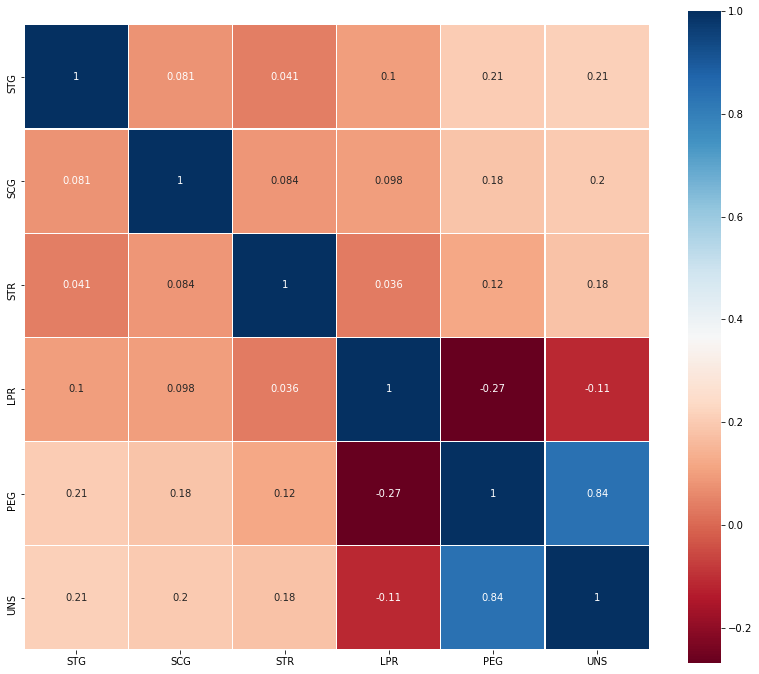

In [816]:
import seaborn as sns

plt.figure(figsize=(14,12))
sns.heatmap(students_data.corr(),
            linewidths=0.1, vmax=1.0,
            square=True, cmap='RdBu', linecolor='white', annot=True)

Text(0.5, 1.0, 'Порог — значение функционала качества')

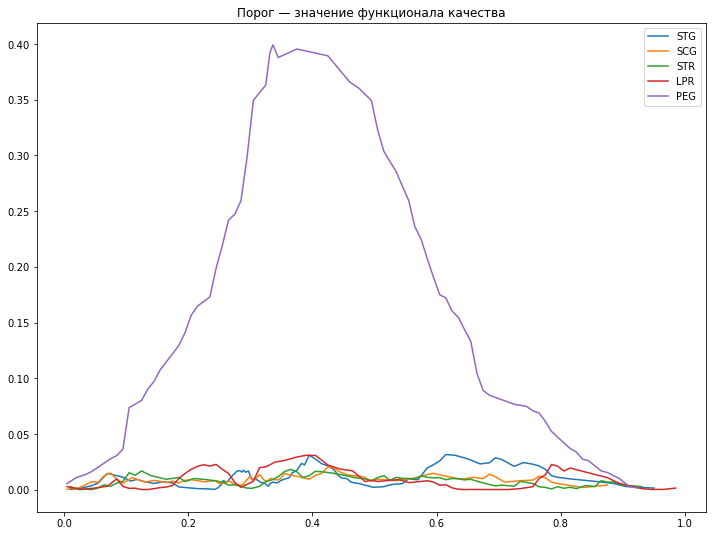

In [817]:
plt.figure(figsize=(12,9))

for i in X:
    thresholds, Q, threshold_best, Q_best = find_best_split(
    X[i].to_numpy(), 
    y, 
    task="classification",
    feature_type="real"
    )
    plt.plot(thresholds, Q)
plt.legend(X)
plt.title("Порог — значение функционала качества")

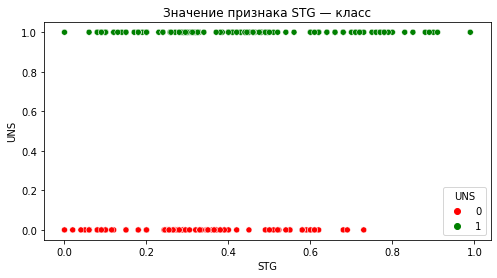

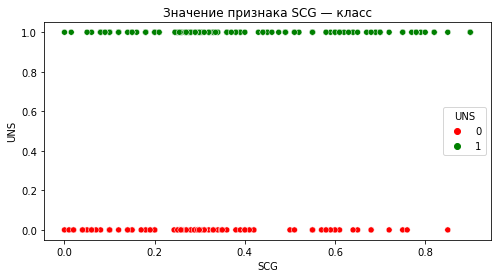

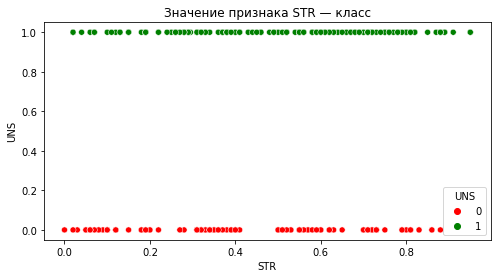

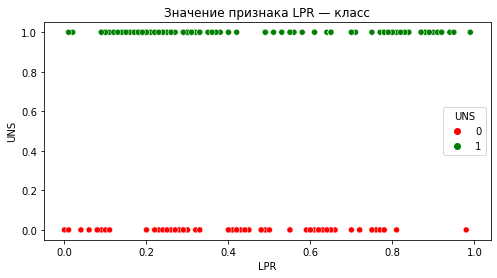

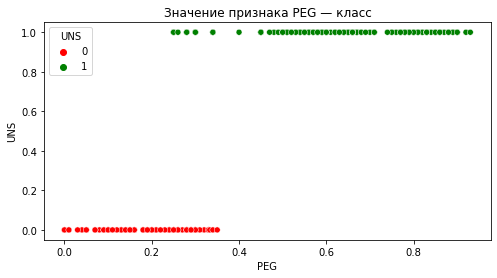

In [818]:
colors = ['#FF0000', '#008000'] 
for i in X:
    plt.figure(figsize = (8,4))
    sns.scatterplot(x=X[i].to_numpy(), y=y,hue = y, palette = colors)
    plt.xlabel(i)
    plt.title(f"Значение признака {i} — класс")
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [819]:
# Деление очевидно нужно производить по признаку PEG, так как на графике Порог — значение функционала качества
# линия именно этого признака проходит выше остальных, что означает огромное превосходство в функционале качества
# перед остальными признаками (по нему собственно и происходит деление). Также на хитмапе с корреляциями видно, что
# этот признак (PEG) имеет огромную корреляцию с целевой переменной (Построил для наглядности). Ну и на графиках 
# рассеяния видно, что по этому признаку можно почти идеально разбить нашу выборку взяв порог чуть меньше 0,4
# Идеальный график (порог - значение функционала качества) выглядит как график с максимумумом в максимальном 
# значении функционала качества (равно критерию информативности в корневой вершине), неподходящие же признаки
# не принимают большого значения Q ни при каком из порогов.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [853]:
from sklearn.preprocessing import LabelEncoder

mushrooms = pd.read_csv("agaricus-lepiota.data")

le = LabelEncoder()
mushrooms[mushrooms.columns] = mushrooms[mushrooms.columns].apply(le.fit_transform)

X = mushrooms.drop(columns = "p")
y = mushrooms["p"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=13) 

In [859]:
X_train

x  s  n  t  p.1  f  c  n.1   k  e  ...  s.2  w  w.1  p.2  w.2  o  p.3  \
6912  5  2  2  0    2  1  0    1   0  1  ...    2  7    7    0    2  1    0   
2497  5  0  2  1    5  1  0    0   5  1  ...    2  6    6    0    2  1    4   
4492  5  3  3  0    2  1  0    0   7  0  ...    1  6    4    0    2  1    2   
7742  3  0  3  0    5  1  1    0   7  0  ...    1  7    7    0    2  2    4   
4368  2  3  9  0    2  1  0    0   7  0  ...    1  0    6    0    2  1    2   
...  .. .. .. ..  ... .. ..  ...  .. ..  ...  ... ..  ...  ...  ... ..  ...   
2790  5  3  2  1    5  1  0    0  10  1  ...    2  3    6    0    2  1    4   
7696  3  3  2  0    2  1  0    1   0  1  ...    1  7    6    0    2  1    0   
74    2  2  9  1    3  1  1    1   7  1  ...    2  7    7    0    2  1    4   
6320  5  2  2  0    8  1  0    1   0  1  ...    2  6    6    0    2  1    0   
338   5  3  4  1    3  1  0    0   5  0  ...    3  7    7    0    2  1    4   

      k.1  s.3  u  
6912    7    4  0  
2497    3    4  0  
4492    1    5  4  
7742    7    3  1  
4368    1    4  4  
...   ...  ... ..  
2790    2    5  0  
7696    7    4  2  
74      3    4  0  
6320    7    4  4  
338     2    5  1  

[4061 rows x 22 columns]

In [860]:
from sklearn.metrics import accuracy_score

custom_dt = DecisionTree(task = 'classification', feature_types = ['categorical', "categorical", "categorical", 
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical", "categorical", "categorical",
                                                                  "categorical"])
custom_dt.fit(np.array(X_train), np.array(y_train))

accuracy_score(np.array(y_test), custom_dt.predict(np.array(X_test)))

<ipython-input-807-ad18a501a222>:53: RuntimeWarning: invalid value encountered in long_scalars
  H_r = gini(np.sum(target_vector[~mask], axis = 0)/len(target_vector[~mask]))


0.9972919743968488

In [861]:
from sklearn.metrics import accuracy_score

custom_dt = DecisionTree(task = 'classification', feature_types = ['real', "real", "real", 
                                                                  "real", "real", "real",
                                                                  "real", "real", "real",
                                                                  "real", "real", "real",
                                                                  "real", "real", "real",
                                                                  "real", "real", "real",
                                                                  "real", "real", "real",
                                                                  "real"])
custom_dt.fit(np.array(X_train), np.array(y_train))

accuracy_score(np.array(y_test), custom_dt.predict(np.array(X_test)))

<ipython-input-807-ad18a501a222>:37: RuntimeWarning: invalid value encountered in long_scalars
  H_r = gini(np.sum(target_vector[~mask], axis = 0)/R_r)


0.9980305268340719

In [862]:
# Интересное наблюдение, если рассматривать наши признаки, как вещественные, то доля правильных ответов выше.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [595]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [596]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

Посмотрим на распределение целевой переменной

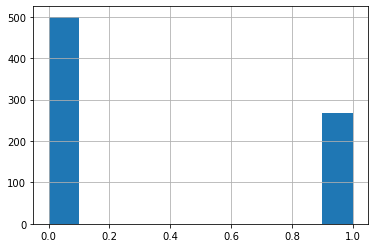

In [597]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [863]:
from sklearn.model_selection import train_test_split 

X = pd.DataFrame(data = data, columns = data.columns[:-1])
y = data["Outcome"]

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13) 

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.3, random_state=13) 

y_train.shape, y_val.shape, y_test.shape

((375,), (162,), (231,))

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [599]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

for i,j in [[3,1], [4, 1], [5,1], [6,1], 
           [3,2], [4, 2], [5,2], [6,2],
           [3,4], [4, 4], [5,4], [6,4],
           [3,6], [4, 6], [5,6], [6,6]]:
    
    dt = DecisionTreeClassifier(max_depth = i, min_samples_leaf=j)
    dt.fit(X_train, y_train)
    print(f"max_depth, min_samples_leaf = {i}, {j} -- {f1_score(y_val, dt.predict(X_val))}\n")

max_depth, min_samples_leaf = 3, 1 -- 0.611111111111111

max_depth, min_samples_leaf = 4, 1 -- 0.6511627906976744

max_depth, min_samples_leaf = 5, 1 -- 0.6530612244897959

max_depth, min_samples_leaf = 6, 1 -- 0.6017699115044248

max_depth, min_samples_leaf = 3, 2 -- 0.611111111111111

max_depth, min_samples_leaf = 4, 2 -- 0.6590909090909092

max_depth, min_samples_leaf = 5, 2 -- 0.6597938144329897

max_depth, min_samples_leaf = 6, 2 -- 0.6126126126126127

max_depth, min_samples_leaf = 3, 4 -- 0.611111111111111

max_depth, min_samples_leaf = 4, 4 -- 0.627906976744186

max_depth, min_samples_leaf = 5, 4 -- 0.6521739130434782

max_depth, min_samples_leaf = 6, 4 -- 0.6055045871559632

max_depth, min_samples_leaf = 3, 6 -- 0.5849056603773585

max_depth, min_samples_leaf = 4, 6 -- 0.627906976744186

max_depth, min_samples_leaf = 5, 6 -- 0.6526315789473683

max_depth, min_samples_leaf = 6, 6 -- 0.6194690265486724



In [600]:
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=6, random_state=41)
dt.fit(X_full_train, y_full_train)

print(classification_report(y_test, dt.predict(X_test)))
print(f"AUC_ROC: {roc_auc_score(y_test, dt.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.67      0.52      0.58        87

    accuracy                           0.72       231
   macro avg       0.71      0.68      0.69       231
weighted avg       0.72      0.72      0.71       231

AUC_ROC: 0.6822318007662835


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [601]:
bc = BaggingClassifier(n_estimators = 50, random_state = 41)
bc.fit(X_full_train, y_full_train)

print(classification_report(y_test, bc.predict(X_test)))
print(f"AUC_ROC: {roc_auc_score(y_test, bc.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       144
           1       0.72      0.64      0.68        87

    accuracy                           0.77       231
   macro avg       0.76      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231

AUC_ROC: 0.7454501915708812


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [837]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import sklearn
for i,j in [[5,1], [10, 1], [20,1], [25,1], 
           [5,2], [10, 2], [20,2], [25,2],
           [5,3], [10, 3], [20,3], [25,3],
           [5,4], [10, 4], [20,4], [25,4]]:
    rf = RandomForestClassifier(n_estimators=50, max_depth = i, min_samples_leaf=j, random_state= 41)
    f1 = cross_val_score(estimator = rf, X = X_full_train, y = y_full_train, cv = 5, scoring='f1').mean()
    print(f"max_depth, min_samples_leaf = {i}, {j} -- {f1}")

max_depth, min_samples_leaf = 5, 1 -- 0.6084696729472849
max_depth, min_samples_leaf = 10, 1 -- 0.6203846967724349
max_depth, min_samples_leaf = 20, 1 -- 0.6131767775603392
max_depth, min_samples_leaf = 25, 1 -- 0.6131767775603392
max_depth, min_samples_leaf = 5, 2 -- 0.6102309288635721
max_depth, min_samples_leaf = 10, 2 -- 0.6190195698360756
max_depth, min_samples_leaf = 20, 2 -- 0.6436919173906315
max_depth, min_samples_leaf = 25, 2 -- 0.6436919173906315
max_depth, min_samples_leaf = 5, 3 -- 0.6198948332342085
max_depth, min_samples_leaf = 10, 3 -- 0.6218266866154191
max_depth, min_samples_leaf = 20, 3 -- 0.6211829700354291
max_depth, min_samples_leaf = 25, 3 -- 0.6211829700354291
max_depth, min_samples_leaf = 5, 4 -- 0.6028347559943322
max_depth, min_samples_leaf = 10, 4 -- 0.6205208851282829
max_depth, min_samples_leaf = 20, 4 -- 0.6142016380891061
max_depth, min_samples_leaf = 25, 4 -- 0.6142016380891061


In [840]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, min_samples_leaf=2, random_state = 41)
rf.fit(X_full_train, y_full_train)

print(classification_report(y_test, rf.predict(X_test)))
print(f"AUC_ROC: {roc_auc_score(y_test, rf.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       144
           1       0.76      0.61      0.68        87

    accuracy                           0.78       231
   macro avg       0.77      0.75      0.75       231
weighted avg       0.78      0.78      0.77       231

AUC_ROC: 0.7455699233716475


In [ ]:
# Как обсуждалось хуже всего себя показало одиночное решающее дерево, однако их в одиночку почти никогда и не 
# использует. А вот случайный лес и бэггинг как раз показали что деревья лучше себя чувствуют в ансамблях. 
# Лучшее качество получилось у случайного леса хоть и не намного.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

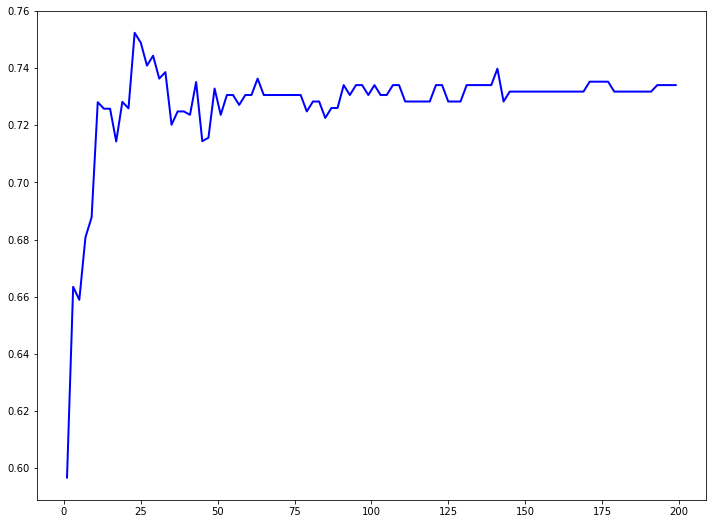

In [841]:
from sklearn.metrics import roc_auc_score

n_trees = range(1,200, 2)

auc_roc = []

for i in n_trees:
    rf = RandomForestClassifier(n_estimators = i, random_state = 41)
    rf.fit(X_full_train, y_full_train)
    auc_roc.append(roc_auc_score(y_test, rf.predict(X_test)))
plt.figure(figsize= (12, 9))
plt.plot(n_trees, auc_roc, linestyle = '-', linewidth = 2, color = 'blue')
plt.show()

# В начале до какого то числа деревьев auc-roc растет, однако потом выходит на ассимптоту, что еще раз показывает 
# то, что random forest не переобучается при росте количества деревьев, но и смысла это не несет.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

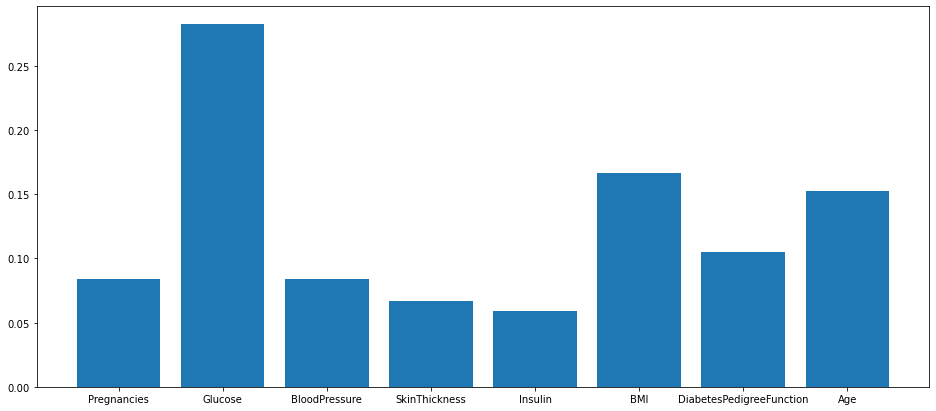

In [864]:
rf = RandomForestClassifier(n_estimators = 50,max_depth=20, min_samples_leaf=2, random_state = 41)
rf.fit(X_full_train, y_full_train)

plt.figure(figsize = (16, 7))

plt.bar(X.columns, rf.feature_importances_);

In [843]:
# Признак Glucose оказался самым важным, что вполне очевидно.